# Simple calibration example

True process: $\zeta = \frac{\theta x}{1+x/a}$

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pymc as pm
import scipy

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
x= np.linspace(0,6,100) # x values
xReg = np.linspace(0.1,4,11) # regularly spaced observations
xRan = np.random.uniform(0.1,4,11) # randomly located observations

In [6]:
theta = 0.65
a = 20
eta = theta*x
zeta = theta*x/(1+x/a) #true process
zReg = theta*xReg/(1+xReg/a)+np.random.normal(0,0.001,len(xReg)) #Regularly spaced observations
zRan = theta*xRan/(1+xRan/a)+np.random.normal(0,0.001,len(xRan)) #Randomly spaced observations

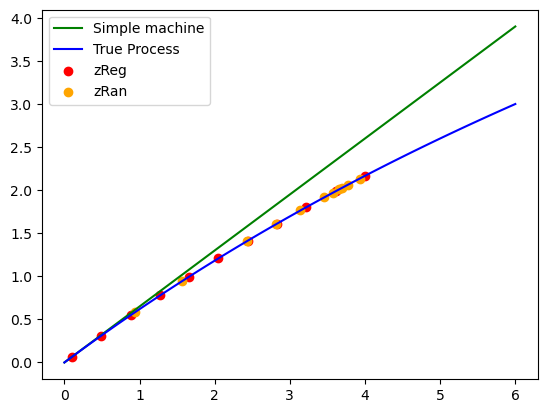

In [7]:
plt.plot(x,eta,color='g')
plt.plot(x,zeta,color='b')
plt.scatter(xReg,zReg,color='r')
plt.scatter(xRan,zRan,color='orange') 
plt.legend(['Simple machine','True Process','zReg', 'zRan'])

In [8]:
np.array([zReg,xReg]).T

array([[0.06478614, 0.1       ],
       [0.31076369, 0.49      ],
       [0.5483734 , 0.88      ],
       [0.77777827, 1.27      ],
       [0.99668698, 1.66      ],
       [1.2087044 , 2.05      ],
       [1.41368679, 2.44      ],
       [1.6125984 , 2.83      ],
       [1.8027587 , 3.22      ],
       [1.98701156, 3.61      ],
       [2.16507139, 4.        ]])

# Bayesian Linear Regression using Bambi

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [zReg_sigma, xReg]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 34 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [zRan_sigma, xRan]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 46 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xReg,0.563,0.008,0.548,0.577,0.0,0.0,2755.0,2313.0,NaN
zReg_sigma,0.060,0.017,0.035,0.088,0.0,0.0,3067.0,2500.0,NaN


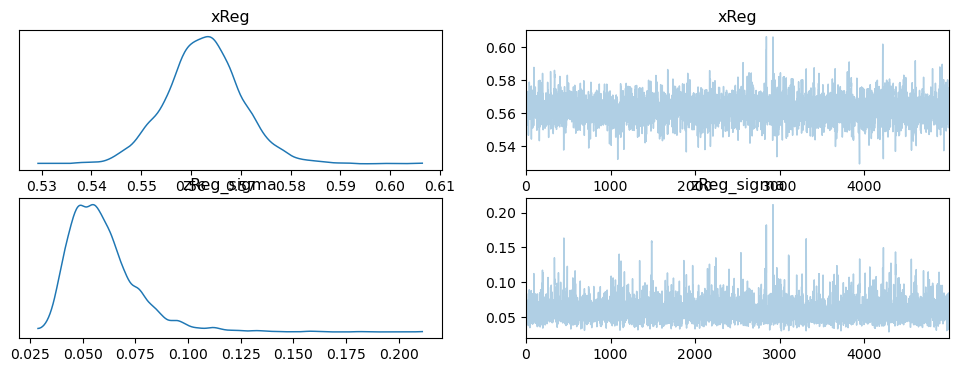

In [9]:
import arviz as az
import bambi as bmb
import pandas as pd

# Read in a tab-delimited file containing our data
dataReg = pd.DataFrame(data=np.array([zReg,xReg]).T, columns=["zReg","xReg"])
dataRan = pd.DataFrame(data=np.array([zRan,xRan]).T, columns=["zRan","xRan"])

# Initialize the fixed effects only model
modelReg = bmb.Model('zReg ~ 0 + xReg', dataReg)
modelRan = bmb.Model('zRan ~ 0 + xRan', dataRan)

#fitted=model.fit()

# Fit the model using 1000 on each of 4 chains
resultsReg = modelReg.fit(draws=5000, chains=1)
resultsRan = modelRan.fit(draws=5000, chains=1)

# Use ArviZ to plot the results
az.plot_trace(resultsReg)

# Key summary and diagnostic info on the model parameters
az.summary(resultsReg)


arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xRan,0.555,0.005,0.546,0.565,0.0,0.0,3133.0,2556.0,NaN
zRan_sigma,0.051,0.013,0.030,0.076,0.0,0.0,3181.0,2858.0,NaN


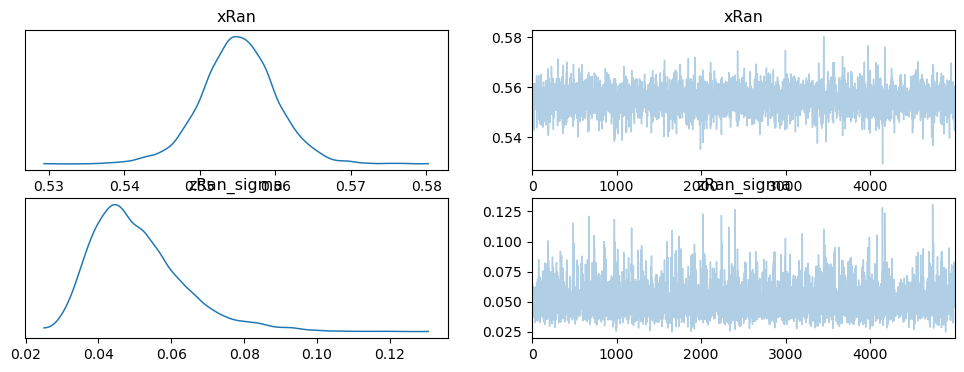

In [10]:
# Use ArviZ to plot the results
az.plot_trace(resultsRan)

# Key summary and diagnostic info on the model parameters
az.summary(resultsRan)

In [11]:
modelReg

       Formula: zReg ~ 0 + xReg
        Family: gaussian
          Link: mu = identity
  Observations: 11
        Priors: 
    target = mu
        Common-level effects
            xReg ~ Normal(mu: 0.0, sigma: 1.3453)
        
        Auxiliary parameters
            zReg_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.6637)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [xReg, zReg_sigma]


array([<Axes: title={'center': 'zReg_sigma'}>,
       <Axes: title={'center': 'xReg'}>], dtype=object)

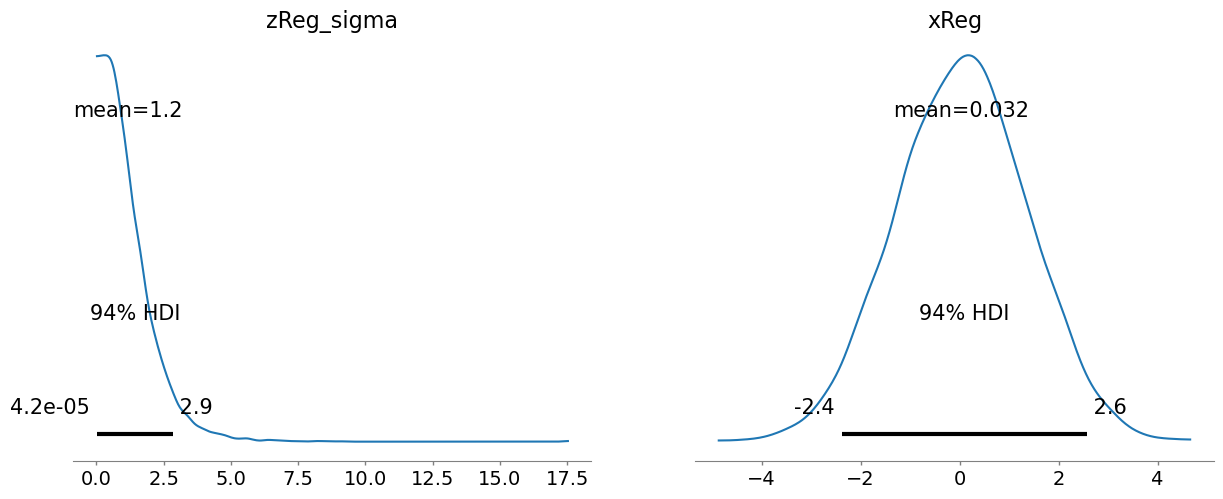

In [12]:
modelReg.plot_priors()

# GP Model Discrepancy

$z$: observations (nx1)

$x$: observation locations (nx1)

$\delta_0$ Model discrepancy at 6 chosen points

$\delta_r$ Model discrepancy at remaining points

$H$: nx6 matrix used to calculate conditional mean of $\delta_r$ given $\delta_0$

$\Gamma(\phi)$: Gaussian correlation function with lengthscale $\phi$

In [13]:
xo = xReg[[0,2,4,6,8,10]]
xr = xReg[[1,3,5,7,9]]

In [14]:
zo = zReg[[0,2,4,6,8,10]]
zr = zReg[[1,3,5,7,9]]

In [15]:
def createGamma(x1,x2,phi):
    gamma = np.zeros([len(x1),len(x2)])
    for i,xi in enumerate(x1):
        for j,xj in enumerate(x2):
            gamma[i,j] = np.exp(-((xi-xj)/phi)**2)
    return gamma

In [16]:
def createH(xo,xr,phi):
    
    H = np.zeros([len(xr)+len(xo),len(xo)])
    H[0:len(xo),:]=np.identity(len(xo))
    gamma_ro = createGamma(xr,xo,phi)
    gamma_oo = createGamma(xo,xo,phi)
    H[len(xo):len(xr)+len(xo),:] = np.matmul(gamma_ro,np.linalg.inv(gamma_oo))
    return H

In [17]:
def ThetaConditional(xo,xr,xp,zo,zr,sigma_e,phi):
        
    x=np.hstack((xo,xr))[:,None]
    z=np.hstack((zo,zr))[:,None]
    H = createH(xo,xr,phi)
    gamma_opop = createGamma(np.hstack((xo,xp)),np.hstack((xo,xp)),phi)
    A=np.hstack((H,np.zeros([len(xo)+len(xr),len(xp)])))
    m1=(1/sigma_e**2)*np.matmul(x.T,z)
    m2=(1/sigma_e**2)*np.matmul(H.T,z)
    m3 = np.zeros((len(xp),1))
    m = np.vstack((m1,m2,m3)) 
    
                  
    sigma1 = (1/sigma_e**2)*np.matmul(x.T,x)
    sigma2 = (1/sigma_e**2)*np.matmul(x.T,A)
    sigma3 = (1/sigma_e**2)*np.matmul(A.T,x)
    sigma4 = (1/sigma_e**2)*np.matmul(A.T,A) + (1/sigma_e**2)*np.linalg.inv(gamma_opop)
    sigma = np.vstack((np.hstack((sigma1, sigma2)), np.hstack((sigma3, sigma4))))
    sigmaInv = np.linalg.inv(np.array(sigma))
    mu = np.squeeze(np.matmul(sigmaInv,m))
    
    return mu, sigmaInv
                  

In [18]:
def sigma2Conditional(a,b,xo,phi,deltao):
    gamma_oo = createGamma(xo,xo,phi)
    mean = a + 0.5*len(xo)
    shape = b + 0.5*np.matmul(np.matmul(deltao.T,gamma_oo),deltao)
    return mean, shape

In [19]:
def sigma_e2Conditional(a_e,b_e,xo,xr,zo,zr,phi,theta,deltao):
    x=np.hstack((xo,xr))
    z=np.hstack((zo,zr))
    H = createH(xo,xr,phi)
    gamma_oo = createGamma(xo,xo,phi)
    mean = a_e + 0.5*(len(xo)+len(xr))
    shape = b_e + 0.5*np.matmul((z-theta*x-np.matmul(H,deltao)).T,z-theta*x-np.matmul(H,deltao))
    return mean, shape

In [30]:
def phiChoiceProbability(omega_old,omega_new,xo,xr,a_phi,b_phi,deltao,sigma2,sigma_e2):
    x=np.hstack((xo,xr))
    z=np.hstack((zo,zr))
    H_old = createH(xo,xr,np.exp(omega_old))
    H_new = createH(xo,xr,np.exp(omega_new))
    gamma_old = createGamma(xo,xo,np.exp(omega_old))
    gamma_new = createGamma(xo,xo,np.exp(omega_new))
    logr =  0.5*np.log(np.linalg.det(gamma_old)) - 0.5*np.log(np.linalg.det(gamma_new))+(omega_new-omega_old)*a_phi-(np.exp(omega_new)-np.exp(omega_old))*b_phi - (1/(2*sigma2))*np.matmul(np.matmul(deltao.T,np.linalg.inv(gamma_new)-np.linalg.inv(gamma_old)),deltao)-(1/(2*sigma_e2))*np.matmul((z-theta*x-np.matmul(H_new,deltao)).T,(z-theta*x-np.matmul(H_new,deltao)))+(1/(2*sigma_e2))*np.matmul((z-theta*x-np.matmul(H_new,deltao)).T,(z-theta*x-np.matmul(H_old,deltao)))
    return logr

In [31]:
def gibbs_sampler(theta,deltao,deltap,sigma2,sigma_e2,phi, num_samples, xo, xr, xp, zo, zr,tau2,a,b,a_e,b_e,a_phi,b_phi):
    dim = 1+len(deltao)+len(deltap)+1+1+1
    samples = np.empty([num_samples+1, dim])  #sampled points
    samples[0] = np.hstack((theta,deltao,deltap,sigma2,sigma_e2,phi))
    param = np.hstack((theta,deltao,deltap))
    for i in range(num_samples):
        mu, sigma = ThetaConditional(xo,xr,xp,zo,zr,np.sqrt(sigma_e2),phi)
        param = np.random.multivariate_normal(mu,sigma)
        
        mean, shape = sigma2Conditional(a,b,xo,phi,deltao)
        
        sigma2 = np.random.wald(mean,shape)
        
        mean, shape = sigma_e2Conditional(a_e,b_e,xo,xr,zo,zr,phi,theta,deltao)
        sigma_e2 = np.random.wald(mean,shape)
        

        omega_old = np.log(phi)
        
        omega_new = np.minimum(np.random.normal(omega_old,tau2),np.log(4))
        
        r = phiChoiceProbability(omega_old,omega_new,xo,xr,a_phi,b_phi,deltao,sigma2,sigma_e2)
        
        if np.random.uniform(0,1)<np.exp(r):
            phi = np.exp(omega_new)
        
        samples[i+1] = np.hstack((param,sigma2,sigma_e2,phi))
    return samples

In [32]:
xp=[1,2,3]

In [45]:
samples = gibbs_sampler(theta,deltao=np.zeros(len(xo)),deltap=np.zeros(len(xp)),sigma2=0.1,sigma_e2=0.1,phi=0.1, num_samples=100000, xo=xo, xr=xr, xp=xp, zo=zo, zr=zr,tau2=0.01,a=0,b=0.001,a_e=0,b_e=0.001,a_phi=0.,b_phi=0.0001)

C:\Users\chris\AppData\Local\Temp\ipykernel_3352\2682264799.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  param = np.random.multivariate_normal(mu,sigma)


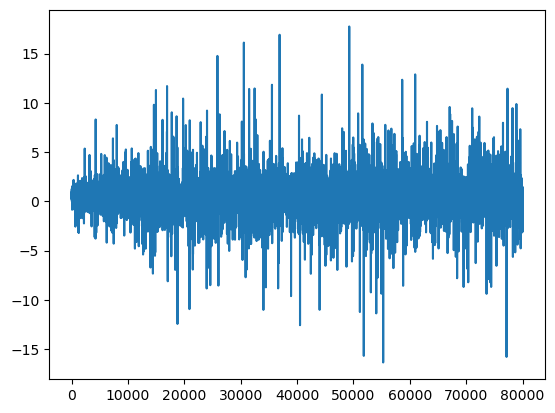

In [47]:
plt.plot(samples[20000:,0])

In [49]:
np.mean(samples[20000:,0])

0.5505206080445626